In [1]:
!nvidia-smi

Sat May 27 23:21:12 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti      On | 00000000:01:00.0 Off |                  N/A |
| 30%   43C    P8               23W / 310W|    868MiB /  8192MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import os

###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
###
from tqdm import tqdm
from sklearn.model_selection import train_test_split
#
from PIL import Image
#
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from torch import nn
###
from transformers import CLIPModel, CLIPConfig, CLIPVisionModel
#from transformers import AutoModel, AutoTokenizer
#from transformers import TrainingArguments, Trainer
from transformers import default_data_collator
# Callbacks
from transformers import EarlyStoppingCallback 
from transformers.integrations import TensorBoardCallback
from torch.utils.tensorboard import SummaryWriter

2023-05-27 23:49:01.566489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from transformers import CLIPFeatureExtractor, CLIPTokenizer, CLIPTextModel
from transformers import TrainingArguments, AutoTokenizer, CLIPFeatureExtractor

In [3]:
from clip_classes import CLIPTrainer, CLIPDataset
from clip_functions import clip_wrapper_creator
import helper

# Dataset

In [97]:
folder = "/media/andrew/HD-GDU3/498/"
medical_reports = "cleaned_single_image_only_relevant_headings2.csv"
meta_data = "cleaned_single_image_only_relevant_headings_metadata.csv"
image_data = None
image_folder = None
dataset = "NEW_DATASET.csv"
allsentences = "new_pairs_refined.csv"
md_location = folder + meta_data
meta_reports = pd.read_csv(md_location)
sample = meta_reports.head()

In [98]:
early_stop = EarlyStoppingCallback(
    early_stopping_patience = 10.0,
    early_stopping_threshold = 0
)
# ( early_stopping_patience: int = 1early_stopping_threshold: typing.Optional[float] = 0.0 ) 

In [99]:
#TEXT_MODEL = "emilyalsentzer/Bio_ClinicalBERT"
#TEXT_MODEL = "clinical-bert-models-trained-on-pseudo-re-identified-mimic-iii-notes-1.0.0/model_outputs/ClinicalBERT_1b/"
TEXT_MODEL = "clinical-bert-models-trained-on-pseudo-re-identified-mimic-iii-notes-1.0.0/model_outputs/Pubmed_ClinicalBERT_1a/"
IMAGE_MODEL = 'openai/clip-vit-base-patch32'
FINETUNED_MODEL = 'radCLIP2'
CLIP_MODEL = None
TEST_SIZE = 0.20
BATCH_SIZE = 8
GRADIENT_ACCUMULATION = 2
FP_16 = False
RUN_NAME = 'clip-checkpoints-sentences-bioclinbert-1'
BASE_DIR = '/media/andrew/HD-GDU3/498/'
OUTPUT_DIR = BASE_DIR + RUN_NAME
LEARNING_RATE = 3e-5 #3e-6
WEIGHT_DECAY = 0.1 #0.003, between 0 and .1
OPTIMIZER = "AdamW"
CALLBACKS = [TensorBoardCallback, early_stop]
IMAGE_SIZE = 224
MAX_LEN = 80
EPOCHS = 10
MEAN = torch.tensor([0.42695613, 0.42695613, 0.42695613]) #Image Mean
STD = torch.tensor([0.31928246, 0.31928246, 0.31928246]) #Image STD

## Create Training and Validation Set

# Tensorboard

In [100]:
writer = SummaryWriter()

# Training

In [101]:
dataset = pd.read_csv(dataset)

In [102]:
vision_preprocessor = CLIPFeatureExtractor.from_pretrained(IMAGE_MODEL)

In [103]:
#tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [104]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=500,
    logging_steps=10,
    learning_rate=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY, 
    warmup_steps=100,
    fp16=FP_16,
    prediction_loss_only=True,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION, #1
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    report_to='none',
    metric_for_best_model="loss",
    load_best_model_at_end=True
)

In [105]:
DATA_FILE = dataset

In [106]:
from torch.utils.data import Dataset

class CLIPDataset(Dataset):
    def __init__(self, image_paths: list, text: list, mode: str = 'train'):
        self.image_paths = image_paths
        self.tokens = tokenizer(text, 
                                padding = 'max_length',
                                max_length = MAX_LEN, 
                                truncation = True
                               )

        if mode == 'train':
            self.augment = transforms.Compose([
                #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                #transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])
        elif mode == 'test':
            self.augment = transforms.Compose([
                #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask,
                'pixel_values': self.augment(Image.open(self.image_paths[idx]).convert('RGB'))}

    def __len__(self):
        return len(self.image_paths)

In [107]:
df = dataset.dropna()
#test_df = pd.read_csv('test.csv').dropna()
#validate_df = pd.read_csv('validate.csv').dropna()

train_df, test_df = train_test_split(df, test_size=TEST_SIZE)
train_ds = CLIPDataset(image_paths=train_df.image.tolist(),text=train_df.caption.tolist(), mode='train')
test_ds = CLIPDataset(image_paths=test_df.image.tolist(),text=test_df.caption.tolist(), mode='test')
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,collate_fn=default_data_collator)

# Sample Image

In [108]:
def show_data(batch, idx=0):
    # show image
    img = batch['pixel_values'][idx].permute(1, 2, 0)
    img = STD * img + MEAN
    print('Image shape: ', img.shape)
    plt.imshow(img)
    # show text
    text = tokenizer.decode(batch['input_ids'][idx],  skip_special_tokens=True)
    print('Text: ', text)

torch.Size([8, 80])
torch.Size([8, 3, 224, 224])
Image shape:  torch.Size([224, 224, 3])
Text:  in comparison with the study of, the opacification at the left base has substantially cleared. this could have represented either atelectasis or aspiration pneumonia. cardiac silhouette is within normal limits and there is no vascular congestion, pleural effusion, or acute focal pneumonia.


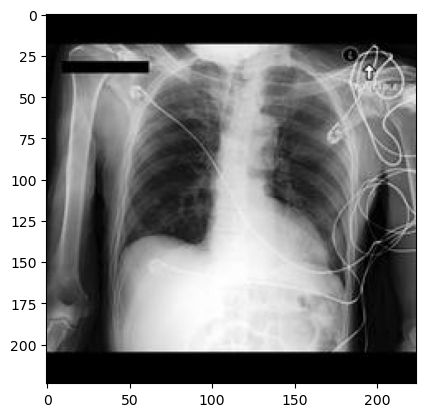

In [109]:
for item in train_dl:
    print(item['input_ids'].shape)
    print(item['pixel_values'].shape)
    break
show_data(item)

In [110]:
vision_encoder = CLIPVisionModel.from_pretrained(IMAGE_MODEL)
#config = CLIPConfig.from_pretrained("openai/clip-vit-base-patch16")
#vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16", config=config.vision_config)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.9.mlp.fc2.bias', 'text_model.encoder.layers.11.self_attn.q_proj.bias', 'text_model.encoder.layers.9.layer_norm1.bias', 'text_model.encoder.layers.4.layer_norm1.bias', 'text_model.encoder.layers.4.layer_norm2.bias', 'text_model.encoder.layers.3.layer_norm2.weight', 'text_model.encoder.layers.3.layer_norm2.bias', 'text_model.encoder.layers.9.self_attn.q_proj.bias', 'text_model.encoder.layers.2.mlp.fc1.bias', 'text_model.encoder.layers.5.layer_norm2.weight', 'text_model.encoder.layers.2.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.5.self_attn.q_proj.bias', 'text_model.encoder.layers.5.layer_norm1.weight', 'text_model.encoder.layers.6.self_attn.v_proj.weight', 'text_model.encoder.layers.7.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.q_proj.bias', 'text_model.

In [111]:
TEXT_MODEL

'clinical-bert-models-trained-on-pseudo-re-identified-mimic-iii-notes-1.0.0/model_outputs/Pubmed_ClinicalBERT_1a/'

In [112]:
text_encoder = CLIPTextModel.from_pretrained(TEXT_MODEL)
#text_encoder = BertModel.from_pretrained("bert-base-uncased")

You are using a model of type bert to instantiate a model of type clip_text_model. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at clinical-bert-models-trained-on-pseudo-re-identified-mimic-iii-notes-1.0.0/model_outputs/Pubmed_ClinicalBERT_1a/ were not used when initializing CLIPTextModel: ['bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.self.value.weight', 'bert.encoder.layer.11.attention.self.value.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.9.attention.self.query.weight', 'bert.encoder.layer.8.output.dense.bias', 'bert.encoder.layer.10.attention.self.value.bias', 'bert.encoder.layer.4.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.intermediate.dense.weight', 'bert.encoder.layer.1.attention.output.dense.weight', 'bert.encoder.layer.7.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.sel

In [113]:
def clip_wrapper_creator():
    """create a dummy CLIPModel to wrap text and vision encoders in order to use CLIPTrainer"""
    config = {'num_hidden_layers': 0,
              'max_position_embeddings': 0,
              'vocab_size': 0,
              'hidden_size': 1,
              'patch_size': 1,
              }

    #DUMMY_CONFIG = CLIPConfig(text_config_dict=config,vision_config_dict=config)
    DUMMY_CONFIG = CLIPConfig(
        text_config_dict = config,
        vision_config_dict = config
    )

    clip = CLIPModel(config=DUMMY_CONFIG)

    # convert projectors to Identity
    clip.text_projection = nn.Identity()
    clip.visual_projection = nn.Identity()

    return clip

In [114]:
#text_encoder = AutoModel.from_pretrained(TEXT_MODEL)
#text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')

clip = clip_wrapper_creator()
clip.text_model = text_encoder
clip.vision_model = vision_encoder

In [115]:
assert text_encoder.config.hidden_size == vision_encoder.config.hidden_size

## Trainer: train using huggingface trainer

In [116]:
def train_model():
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    helper.clear_gpu()
    args.dataloader_num_workers = helper.optimal_workers()
    trainer = CLIPTrainer(clip, args,
                          train_dataset=train_ds,
                          eval_dataset=test_ds,
                          callbacks = CALLBACKS
                         )

    trainer.train()

In [117]:
activate_training = False

In [118]:
if activate_training:
    
    train_model()

    # save pretrained models
    # clip.text_model.save_pretrained('radCLIP')
    # tokenizer.save_pretrained('radCLIP')
    # clip.vision_model.save_pretrained('radCLIP')
    # vision_preprocessor.save_pretrained('radCLIP')

In [119]:
# save pretrained models
if activate_training:
    clip.text_model.save_pretrained(FINETUNED_MODEL)
    tokenizer.save_pretrained(FINETUNED_MODEL)
    clip.vision_model.save_pretrained(FINETUNED_MODEL)
    vision_preprocessor.save_pretrained(FINETUNED_MODEL)

# Demo

In [120]:
class VisionDataset(Dataset):
    preprocess = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ])

    def __init__(self, image_paths: list):
        self.image_paths = image_paths

    def __getitem__(self, idx):
        return self.preprocess(Image.open(self.image_paths[idx]).convert('RGB'))

    def __len__(self):
        return len(self.image_paths)


class TextDataset(Dataset):
    def __init__(self, text: list, tokenizer, max_len):
        self.len = len(text)
        self.tokens = tokenizer(text, padding='max_length',
                                max_length=max_len, truncation=True)

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask}

    def __len__(self):
        return self.len

In [121]:
vision_encoder = CLIPVisionModel.from_pretrained(FINETUNED_MODEL)
tokenizer = AutoTokenizer.from_pretrained(FINETUNED_MODEL)
#tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text_encoder = CLIPTextModel.from_pretrained(FINETUNED_MODEL)

You are using a model of type clip_vision_model to instantiate a model of type clip_text_model. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at radCLIP2 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.8.self_attn.v_proj.bias', 'vision_model.encoder.layers.2.self_attn.out_proj.weight', 'vision_model.encoder.layers.0.layer_norm2.bias', 'vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.layers.8.self_attn.out_proj.bias', 'vision_model.encoder.layers.3.self_attn.v_proj.weight', 'vision_model.encoder.layers.4.mlp.fc1.bias', 'vision_model.encoder.layers.6.layer_norm1.bias', 'vision_model.encoder.layers.5.layer_norm1.weight', 'vision_model.encoder.layers.3.mlp.fc2.bias', 'vision_model.encoder.layers.9.self_attn.v_proj.bias', 'vision_model.encoder.layers.7.self_attn.q_proj.bias', 'vision_model.encoder.layers.7.mlp.fc1.bias', 'vision_model.encoder.layers.10.mlp.fc1.bias', 'vision

In [153]:
import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import default_data_collator


class CLIPDemo:
    def __init__(self, vision_encoder, text_encoder, tokenizer,
                 batch_size: int = 32, max_len: int = MAX_LEN, device='cuda'):
        """ Initializes CLIPDemo
            it has the following functionalities:
                image_search: Search images based on text query
                zero_shot: Zero shot image classification
                analogy: Analogies with embedding space arithmetic.

            Args:
            vision_encoder: Fine-tuned vision encoder
            text_encoder: Fine-tuned text encoder
            tokenizer: Transformers tokenizer
            device (torch.device): Running device
            batch_size (int): Size of mini-batches used to embeddings
            max_length (int): Tokenizer max length

            Example:
            >>> demo = CLIPDemo(vision_encoder, text_encoder, tokenizer)
            >>> demo.compute_image_embeddings(test_df.image.to_list())
            >>> demo.image_search('یک مرد و یک زن')
            >>> demo.zero_shot('./workers.jpg')
            >>> demo.anology('./sunset.jpg', additional_text='دریا')
        """
        self.vision_encoder = vision_encoder.eval().to(device)
        self.text_encoder = text_encoder.eval().to(device)
        self.batch_size = batch_size
        self.device = device
        self.tokenizer = tokenizer
        self.max_len = 70 #MAX_LEN
        self.text_embeddings_ = None
        self.image_embeddings_ = None
        

    def compute_image_embeddings(self, image_paths: list):
        self.image_paths = image_paths
        datalodear = DataLoader(VisionDataset(
            image_paths=image_paths), batch_size=self.batch_size)
        embeddings = []
        with torch.no_grad():
            for images in tqdm(datalodear, desc='computing image embeddings'):
                image_embedding = self.vision_encoder(
                    pixel_values=images.to(self.device)).pooler_output
                embeddings.append(image_embedding)
        self.image_embeddings_ =  torch.cat(embeddings)

    def compute_text_embeddings(self, text: list):
        self.text = text
        dataloader = DataLoader(TextDataset(text=text, tokenizer=self.tokenizer, max_len=self.max_len),
                                batch_size=self.batch_size, collate_fn=default_data_collator)
        embeddings = []
        with torch.no_grad():
            for tokens in tqdm(dataloader, desc='computing text embeddings'):
                image_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                                    attention_mask=tokens["attention_mask"].to(self.device)).pooler_output
                embeddings.append(image_embedding)
        self.text_embeddings_ = torch.cat(embeddings)

    def text_query_embedding(self, query: str = ''):
        tokens = self.tokenizer(query, return_tensors='pt')
        with torch.no_grad():
            text_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                               attention_mask=tokens["attention_mask"].to(self.device)).pooler_output
        return text_embedding

    def image_query_embedding(self, image):
        image = VisionDataset.preprocess(image).unsqueeze(0)
        with torch.no_grad():
            image_embedding = self.vision_encoder(
                image.to(self.device)).pooler_output
        return image_embedding

    def most_similars(self, embeddings_1, embeddings_2):
        values, indices = torch.cosine_similarity(
            embeddings_1, embeddings_2).sort(descending=True)
        return values.cpu(), indices.cpu()

    def zero_shot(self, image_path: str, MAXSENT = 100):
        """ Zero shot image classification with label list 
            Args:
                image_path (str): target image path that is going to be classified
                class_list (list[str]): list of candidate classes 
        """
        image = Image.open(image_path)
        image_embedding = self.image_query_embedding(image)
        values, indices = self.most_similars(image_embedding, self.text_embeddings_)
        for i, sim in zip(indices, torch.softmax(values, dim=0))[:MAXSENT]:
            print(
                f'label: {self.text[i]} | {round(float(sim), 10)}')
        plt.imshow(image)
        plt.axis('off')

    def image_search(self, query: str, top_k=25):
        """ Search images based on text query
            Args:
                query (str): text query 
                image_paths (list[str]): a bunch of image paths
                top_k (int): number of relevant images 
        """
        query_embedding = self.text_query_embedding(query=query)
        _, indices = self.most_similars(self.image_embeddings_, query_embedding)

        matches = np.array(self.image_paths)[indices][:top_k]
        _, axes = plt.subplots(2, int(top_k/2), figsize=(15, 5))
        for match, ax in zip(matches, axes.flatten()):
            ax.imshow(Image.open(match).resize((224, 224)))
            ax.axis("off")
        plt.show()

    def analogy(self, input_image_path: str, additional_text: str = '', input_include=True):
        """ Analogies with embedding space arithmetic.
            Args:
                input_image_path (str): The path to original image 
                image_paths (list[str]): A database of images
        """
        base_image = Image.open(input_image_path)
        image_embedding = self.image_query_embedding(base_image)
        additional_embedding = self.text_query_embedding(query=additional_text)
        new_image_embedding = image_embedding + additional_embedding
        _, indices = self.most_similars(
            self.image_embeddings_, new_image_embedding)

        new_image = Image.open(self.image_paths[indices[1 if input_include else 0]])
        _, ax = plt.subplots(1, 2, dpi=100)
        ax[0].imshow(base_image.resize((250, 250)))
        ax[0].set_title('original image')
        ax[0].axis('off')
        ax[1].imshow(new_image.resize((250, 250)))
        ax[1].set_title('new image')
        ax[1].axis('off')

In [155]:
def image_text_comp(id, MAXSENT = 100):
    search.zero_shot(f'{Demo_image_dataset["image"][id]}', MAXSENT = MAXSENT)
    print ("")
    print (Demo_image_dataset['caption'][id])

In [156]:
Demo_image_dataset = test_df

In [157]:
search = CLIPDemo(vision_encoder, text_encoder, tokenizer)

In [158]:
search.compute_image_embeddings(Demo_image_dataset.image.to_list())

computing image embeddings: 100%|█████████████████████████████████████████████████████████| 473/473 [00:29<00:00, 16.25it/s]


In [159]:
single_terms = [
    'lungs fully expanded', 
    'heart size enlarged',
    'pacemaker', 
    'device', 
    'pneumothorax',
    "pulmonary edema", 
    "mild pulmonary edema", 
    'endotracheal tube',
    'port-a-cath',
    "collapsed",
    'endotracheal tube',
    'bibasilar atelectasis'
]

In [160]:
sentence_terms = [
    'moderate cardiomegaly is increased since , perhaps a function of lower lung volumes. mild to moderate pulmonary edema and small bilateral pleural effusions are stable. no pneumothorax. infusion port catheter ends in the right atrium and atrioventricular pacer leads continuous from the left pectoral pacemaker are all unchanged.',
    'comparison with the study dated at p.m., there has been minimal interval change. the patient is status post left pleurx catheter removal. redemonstrated are bilateral pleural effusions, slightly more prominent on the left. the left pacemaker and right port-a-cath are essentially unchanged. there is no evidence of acute pneumonia or vascular congestion',
    'there is no evidence of pneumothorax. the left pectoral pacemaker and right port-a-cath are in unchanged position. no pleural effusions. slightly lower lung volumes than on location of the previous radiograph. minimal atelectasis at the right lung basis. unchanged normal appearance of the cardiac silhouette',
    'there are two pigtail catheters within the right chest. there is again seen a small right-sided pleural effusion with some loculation along the right lateral chest wall. this appears unchanged. there are no pneumothoraces. there is a left-sided pacemaker. slight blunting of the left cp angle is again seen and unchanged. there are no signs for overt pulmonary edema or focal consolidation.'
    ]

In [129]:
from nltk.tokenize import sent_tokenize

In [130]:
sentences = []
for par in Demo_image_dataset['caption'].values:
    sentences += sent_tokenize(par)
sentences = [*set(sentences)]

In [161]:
reports = []
for par in Demo_image_dataset['caption'].values:
    reports += par
reports = [*set(reports)]

In [162]:
def compute_text_embeddings_experiment(corpus='word'):
    if corpus == 'word':
        search.compute_text_embeddings(single_terms)
    elif corpus == 'sentences':
        search.compute_text_embeddings(sentence_terms)
    elif corpus == 'all_sentences':
        search.compute_text_embeddings(sentences)
    elif corpus == 'all_reports':
        search.compute_text_embeddings(reports)
    else:
        print (f'Corpus not found. Manually run compute_text_embeddings script!')

In [ ]:
compute_text_embeddings_experiment('all_sentences')

computing text embeddings:   6%|███▎                                                     | 105/1786 [00:04<01:13, 22.93it/s]

## Search for images

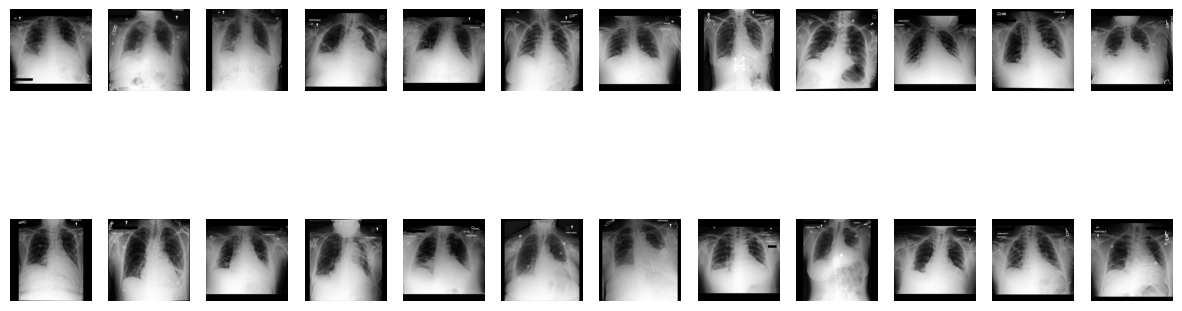

In [141]:
search.image_search('pneumothorax')

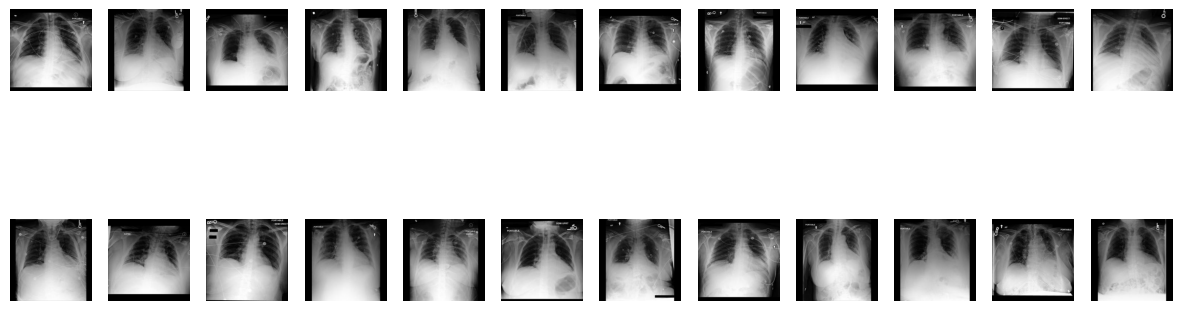

In [140]:
search.image_search('no pneumothorax')

In [135]:
Demo_image_dataset.head(10)

,caption,image
7410,no evidence of pneumothorax status post bronch...,/media/andrew/HD-GDU3/498/complete_imageset/19...
50178,grossly unchanged appearance of bilateral pleu...,/media/andrew/HD-GDU3/498/complete_imageset/13...
71423,previous improvement seen earlier today in bil...,/media/andrew/HD-GDU3/498/complete_imageset/10...
73843,no good evidence of a pneumonia. some congesti...,/media/andrew/HD-GDU3/498/complete_imageset/10...
19725,"in comparison with the study of , there again ...",/media/andrew/HD-GDU3/498/complete_imageset/17...
10740,normal size of the cardiac silhouette. no pleu...,/media/andrew/HD-GDU3/498/complete_imageset/18...
54377,no acute cardiopulmonary process. prior pleura...,/media/andrew/HD-GDU3/498/complete_imageset/12...
74468,"in comparison with chest radiograph, a right s...",/media/andrew/HD-GDU3/498/complete_imageset/10...
25149,no acute cardiac or pulmonary process. there i...,/media/andrew/HD-GDU3/498/complete_imageset/16...
44173,swan-ganz catheter tip is at the level of the ...,/media/andrew/HD-GDU3/498/complete_imageset/14...


In [137]:
Demo_image_dataset['caption'][7410]

'no evidence of pneumothorax status post bronchoscopic biopsy of large right upper lobe mass. a large right upper lung opacity is not significantly changed in size compared to the outside hospital chest radiograph from , corresponding to a cm right upper lobe mass on recent ct from . the lungs are otherwise clear. the heart size is normal. the mediastinal contours are normal. there is no pneumothorax. no pleural effusions. '

## Find all documents with a term. 
This is used to get the row number to use below

In [139]:
substring = 'pneumothorax'
substr = Demo_image_dataset[Demo_image_dataset.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]
substr

,caption,image
7410,no evidence of pneumothorax status post bronch...,/media/andrew/HD-GDU3/498/complete_imageset/19...
71423,previous improvement seen earlier today in bil...,/media/andrew/HD-GDU3/498/complete_imageset/10...
10740,normal size of the cardiac silhouette. no pleu...,/media/andrew/HD-GDU3/498/complete_imageset/18...
74468,"in comparison with chest radiograph, a right s...",/media/andrew/HD-GDU3/498/complete_imageset/10...
25149,no acute cardiac or pulmonary process. there i...,/media/andrew/HD-GDU3/498/complete_imageset/16...
...,...,...
64735,cardiac silhouette is upper limits of normal i...,/media/andrew/HD-GDU3/498/complete_imageset/11...
61416,no focal infiltrate. . there are low lung volu...,/media/andrew/HD-GDU3/498/complete_imageset/11...
37573,in comparison to prior radiograph from earlier...,/media/andrew/HD-GDU3/498/complete_imageset/15...
39386,left chest tube has been removed. there is no ...,/media/andrew/HD-GDU3/498/complete_imageset/14...


In [142]:
for row in substr.head().index:
    print (f'{row}: {substr.caption[row]}')
    print ('')

    #print (df.head()['caption'])

7410: no evidence of pneumothorax status post bronchoscopic biopsy of large right upper lobe mass. a large right upper lung opacity is not significantly changed in size compared to the outside hospital chest radiograph from , corresponding to a cm right upper lobe mass on recent ct from . the lungs are otherwise clear. the heart size is normal. the mediastinal contours are normal. there is no pneumothorax. no pleural effusions. 

71423: previous improvement seen earlier today in bilateral severe perihilar pulmonary consolidation, has reversed. it could be due in part to changes in positive under pressure ventilation support and/or fluid volume, since there was an accompanying transient decrease in cardiac size, particularly right atrium. mild small to moderate right and small left pleural effusion are unchanged. no pneumothorax. tracheostomy tube midline. left pic line ends in the mid svc. no pneumothorax. peg tube ends in distended stomach. 

10740: normal size of the cardiac silhouet

# Get closest text embeddings for an image
Uses the embeddings calculated above

In [152]:
image_text_comp(10740, MAXSENT = 10)

TypeError: zero_shot() got an unexpected keyword argument 'MAXSENT'

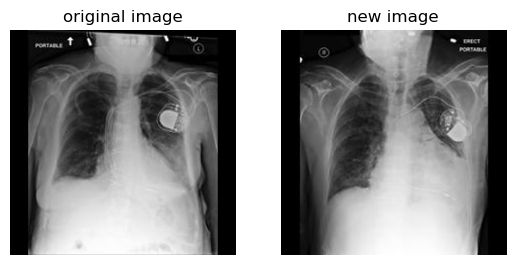

In [62]:
search.analogy(f'{Demo_image_dataset["image"][51]}')